# Final Project Assignment

Name: Ayush Satyavarpu SID: 31648970

# 1. Importing libraries and calibrating cameras

First, let's import all libraries we will need - camutils, visutils, selectpoints, meshutils, pickle, numpy, matplotlib, opencv2, and trimesh.

In [3]:
#import all python files from folder
from camutils import *
from visutils import *
from selectpoints import *
from meshutils import *
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2

The calibrate.py script was run outside of the notebook, and loaded into the calibrate.pickle file.

In [4]:
#load in intrinsic parameters from calibrate.py pickle
calib_pickle = open('calibration.pickle', 'rb')
intrinsic_params = pickle.load(calib_pickle)
calib_pickle.close()

print(intrinsic_params)

{'fx': 1405.3212911679186, 'fy': 1403.9040883422133, 'cx': 962.1638399721529, 'cy': 590.9252815763322, 'dist': array([[-5.23616379e-03,  8.06252724e-02,  2.04808400e-05,
        -3.90754659e-03, -1.08137119e-01]])}


Then, OpenCV's findChessboardCorners method is used to calibrate the cameras. The chessboard is drawn to visualize the points. The points are also drawn in 3d to visualize the environment.

Camera : 
 f=1404.612689755066 
 c=[[962.16383997 590.92528158]] 
 R=[[ 0.03843677  0.98947349  0.13951642]
 [ 0.97735758 -0.00815334 -0.21143721]
 [-0.20807398  0.1444844  -0.9673828 ]] 
 t = [[ 6.86592136 19.52347616 47.34466588]]
Camera : 
 f=1404.612689755066 
 c=[[962.16383997 590.92528158]] 
 R=[[-0.0025982   0.99096859  0.13406904]
 [ 0.9927787  -0.01352313  0.11919555]
 [ 0.11993207  0.13341058 -0.98377737]] 
 t = [[ 7.50034253  7.20907405 47.76536793]]


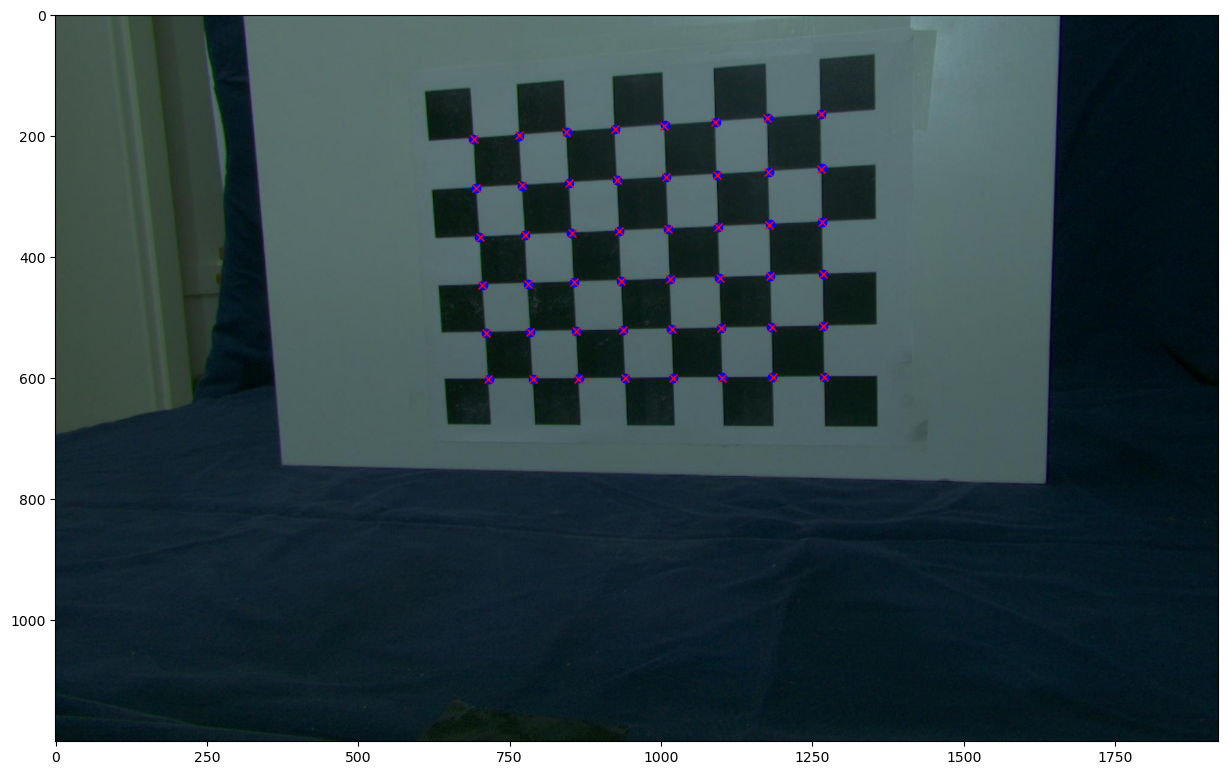

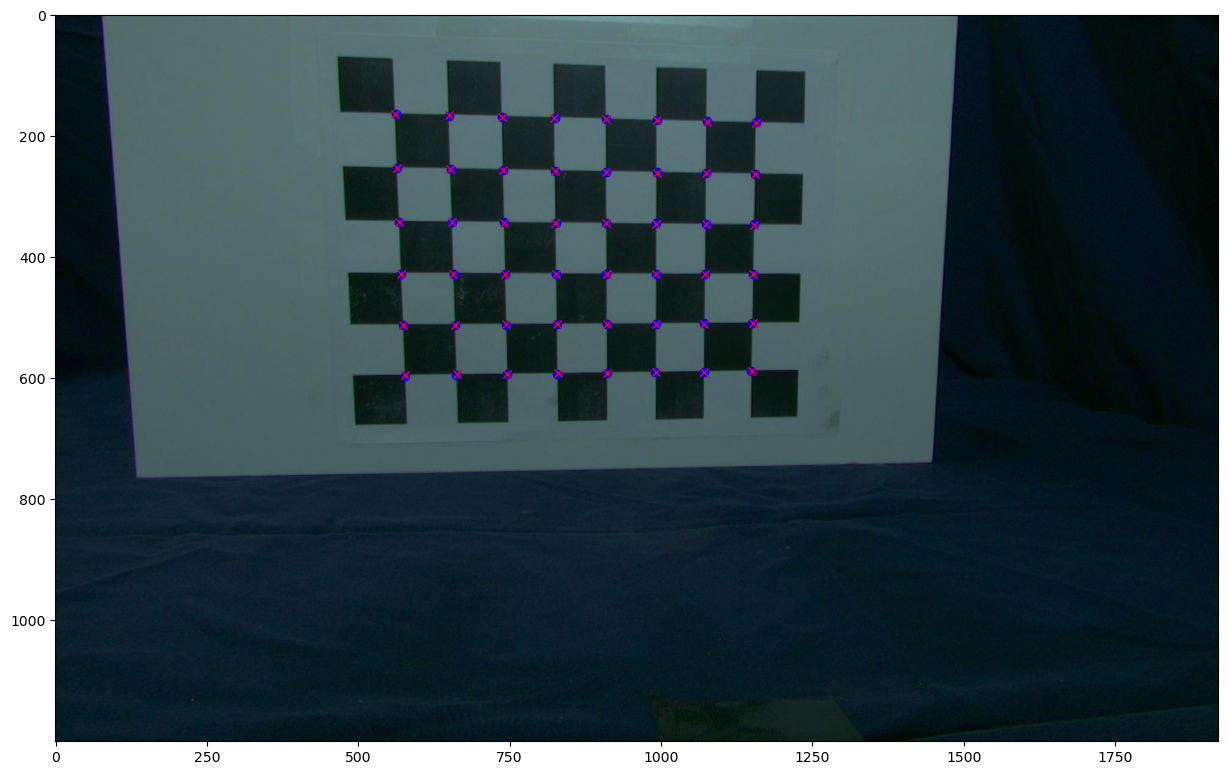

In [5]:
#extrapolate pts2L, pts2R, pts3
camL = Camera((intrinsic_params["fx"] + intrinsic_params["fy"])/2, np.array([[intrinsic_params["cx"]], [intrinsic_params["cy"]]]), np.array([[1, 0, 0], [0,1,0], [0,0,1]]), np.array([[0], [0], [0]]))
camR = Camera((intrinsic_params["fx"] + intrinsic_params["fy"])/2, np.array([[intrinsic_params["cx"]], [intrinsic_params["cy"]]]), np.array([[1, 0, 0], [0,1,0], [0,0,1]]), np.array([[0], [0], [0]]))


imgL = plt.imread("CS117_S20_shared/calib_jpg_u/frame_C0_01.jpg")
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T

imgR = plt.imread("CS117_S20_shared/calib_jpg_u/frame_C1_01.jpg")
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
pts2R = cornersR.squeeze().T

pts3 = np.zeros((3, 6*8))
yy, xx = np.meshgrid(np.arange(8), np.arange(6))
pts3[0, :] = 2.8*xx.reshape(1,-1)
pts3[1, :] = 2.8*yy.reshape(1,-1)

initialL = np.array([0,0,0,0, 0, -300])
initialR = np.array([0,0,0,0,0,-300])
camL = calibratePose(pts3, pts2L, camL, initialL)
camR = calibratePose(pts3, pts2R, camR, initialR)

print(camL)
print(camR)

pts3r = triangulate(pts2L, camL, pts2R, camR)

plt.rcParams['figure.figsize']=[15,15]
pts2Lp = camL.project(pts3)
plt.imshow(imgL)
plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
plt.plot(pts2L[0,:],pts2L[1,:],'rx')
plt.show()

pts2Rp = camR.project(pts3)
plt.imshow(imgR)
plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
plt.plot(pts2R[0,:],pts2R[1,:],'rx')
plt.show()


Text(0, 0.5, 'y')

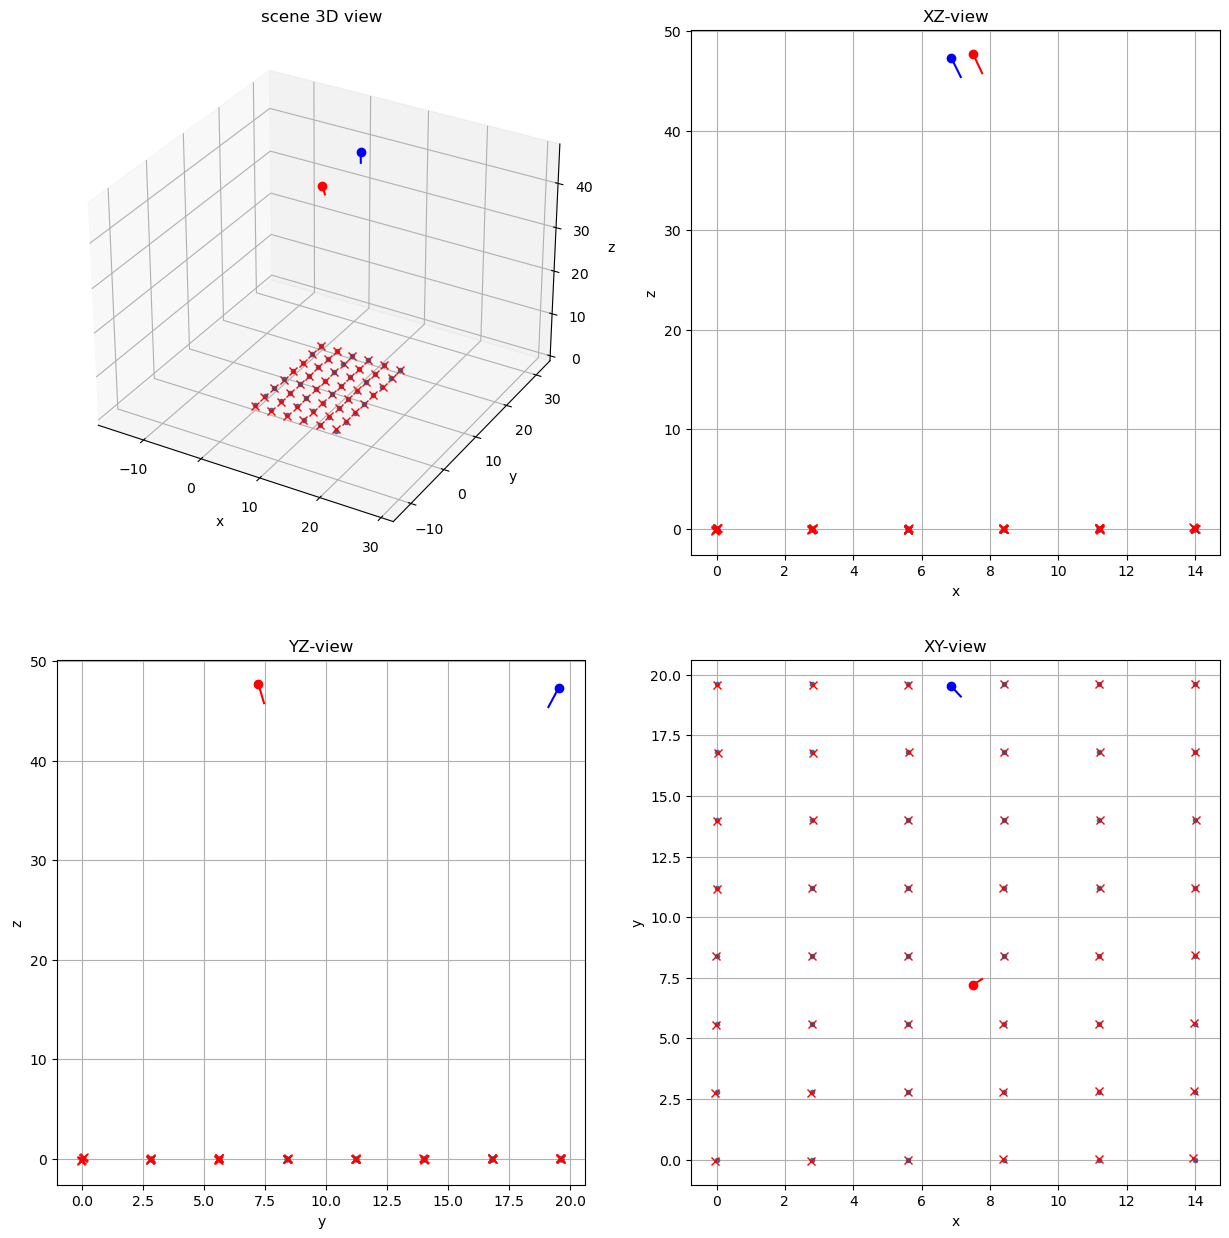

In [6]:
# generate coordinates of a line segment running from the center
# of the camera to 3 units in front of the camera
lookL = np.hstack((camL.t,camL.t+camL.R @ np.array([[0,0,2]]).T))
lookR = np.hstack((camR.t,camR.t+camR.R @ np.array([[0,0,2]]).T))

# visualize the left and right image overlaid
fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
ax.plot(pts3r[0,:],pts3r[1,:],pts3r[2,:],'rx')
ax.plot(camR.t[0],camR.t[1],camR.t[2],'ro')
ax.plot(camL.t[0],camL.t[1],camL.t[2],'bo')
ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
set_axes_equal_3d(ax)
label_axes(ax)
plt.title('scene 3D view')

ax = fig.add_subplot(2,2,2)
ax.plot(pts3[0,:],pts3[2,:],'.')
ax.plot(pts3r[0,:],pts3r[2,:],'rx')
ax.plot(camR.t[0],camR.t[2],'ro')
ax.plot(camL.t[0],camL.t[2],'bo')
ax.plot(lookL[0,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[2,:],'r')
plt.title('XZ-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')

ax = fig.add_subplot(2,2,3)
ax.plot(pts3[1,:],pts3[2,:],'.')
ax.plot(pts3r[1,:],pts3r[2,:],'rx')
ax.plot(camR.t[1],camR.t[2],'ro')
ax.plot(camL.t[1],camL.t[2],'bo')
ax.plot(lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[1,:],lookR[2,:],'r')
plt.title('YZ-view')
plt.grid()
plt.xlabel('y')
plt.ylabel('z')

ax = fig.add_subplot(2,2,4)
ax.plot(pts3[0,:],pts3[1,:],'.')
ax.plot(pts3r[0,:],pts3r[1,:],'rx')
ax.plot(camR.t[0],camR.t[1],'ro')
ax.plot(camL.t[0],camL.t[1],'bo')
ax.plot(lookL[0,:],lookL[1,:],'b')
ax.plot(lookR[0,:],lookR[1,:],'r')
plt.title('XY-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

# 2. Reconstructing the mesh with color

While reconstruct was provided in the libraries imported, we need to modify it to account for the background/foreground masks we will provide and to export color information as well.

In [7]:
#now that we know everything about the cameras, we can start the actual work
#modify reconstruct first
def color_reconstruct(imprefixL,imprefixR,threshold,camL,camR, bgmask_L, bgmask_R, fnameL_fg, fnameR_fg):
    """
    Simple reconstruction based on triangulating matched pairs of points
    between to view which have been encoded with a 20bit gray code.

    Parameters
    ----------
    imprefix : str
      prefix for where the images are stored

    threshold : float
      decodability threshold

    camL,camR : Camera
      camera parameters

    Returns
    -------
    pts2L,pts2R : 2D numpy.array (dtype=float)

    pts3 : 2D numpy.array (dtype=float)

    """

    CLh,maskLh = decode(imprefixL,0,threshold)
    CLv,maskLv = decode(imprefixL,20,threshold)
    CRh,maskRh = decode(imprefixR,0,threshold)
    CRv,maskRv = decode(imprefixR,20,threshold)
    
    imL_fg = plt.imread(fnameL_fg)
    imR_fg = plt.imread(fnameR_fg)

    CL = CLh + 1024*CLv
    assert bgmask_L.shape == maskLh.shape
    maskL = maskLh*maskLv*bgmask_L
    CR = CRh + 1024*CRv
    assert bgmask_R.shape == maskRh.shape
    maskR = maskRh*maskRv*bgmask_R

    h = CR.shape[0]
    w = CR.shape[1]

    subR = np.nonzero(maskR.flatten())
    subL = np.nonzero(maskL.flatten())

    CRgood = CR.flatten()[subR]
    CLgood = CL.flatten()[subL]
    
    _,submatchR,submatchL = np.intersect1d(CRgood,CLgood,return_indices=True)

    matchR = subR[0][submatchR]
    matchL = subL[0][submatchL]

    xx,yy = np.meshgrid(range(w),range(h))
    xx = np.reshape(xx,(-1,1))
    yy = np.reshape(yy,(-1,1))

    pts2R = np.concatenate((xx[matchR].T,yy[matchR].T),axis=0)
    pts2L = np.concatenate((xx[matchL].T,yy[matchL].T),axis=0)
    color2L = imL_fg.reshape((-1, 3))[matchL]
    color2R = imR_fg.reshape((-1, 3))[matchR]
    pts3 = triangulate(pts2L,camL,pts2R,camR)

    return pts2L,pts2R,pts3, color2L.T, color2R.T


The following code detects differences in the background and foreground of the images to give a foreground mask. It is graphed for sanity to ensure the masking is working properly

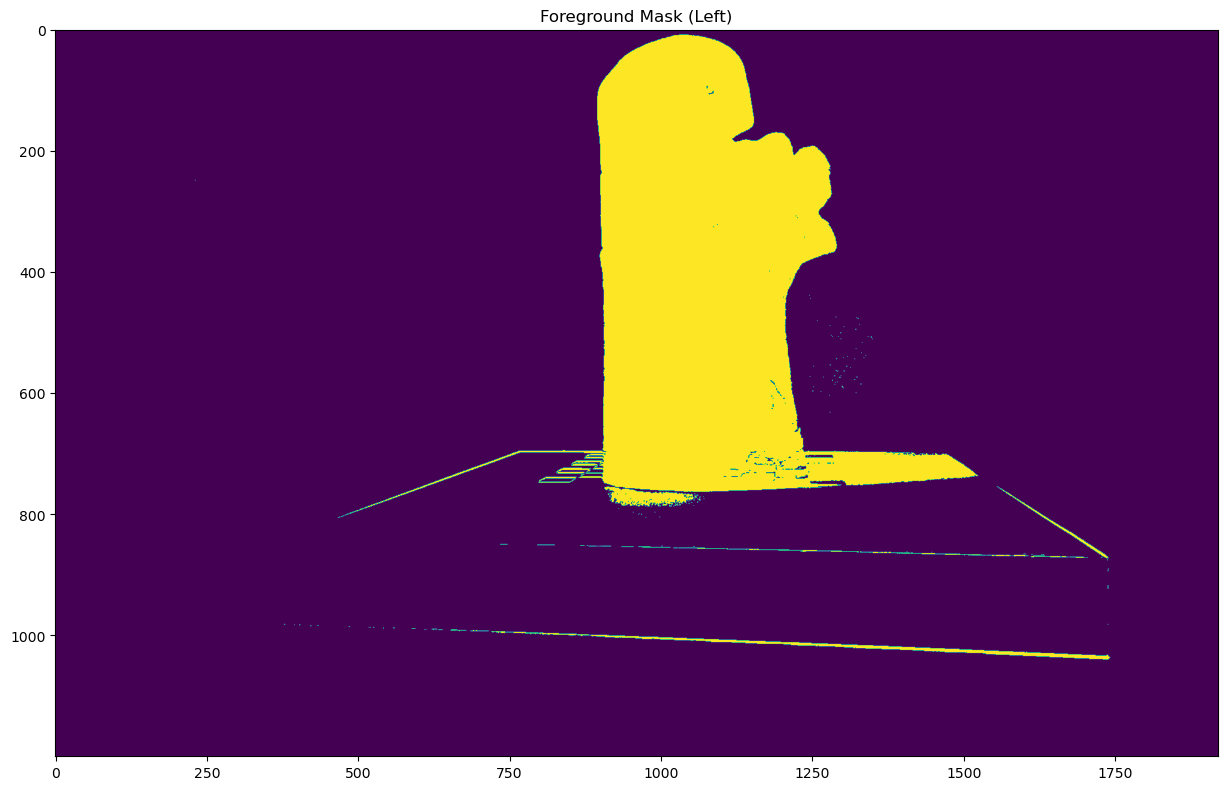

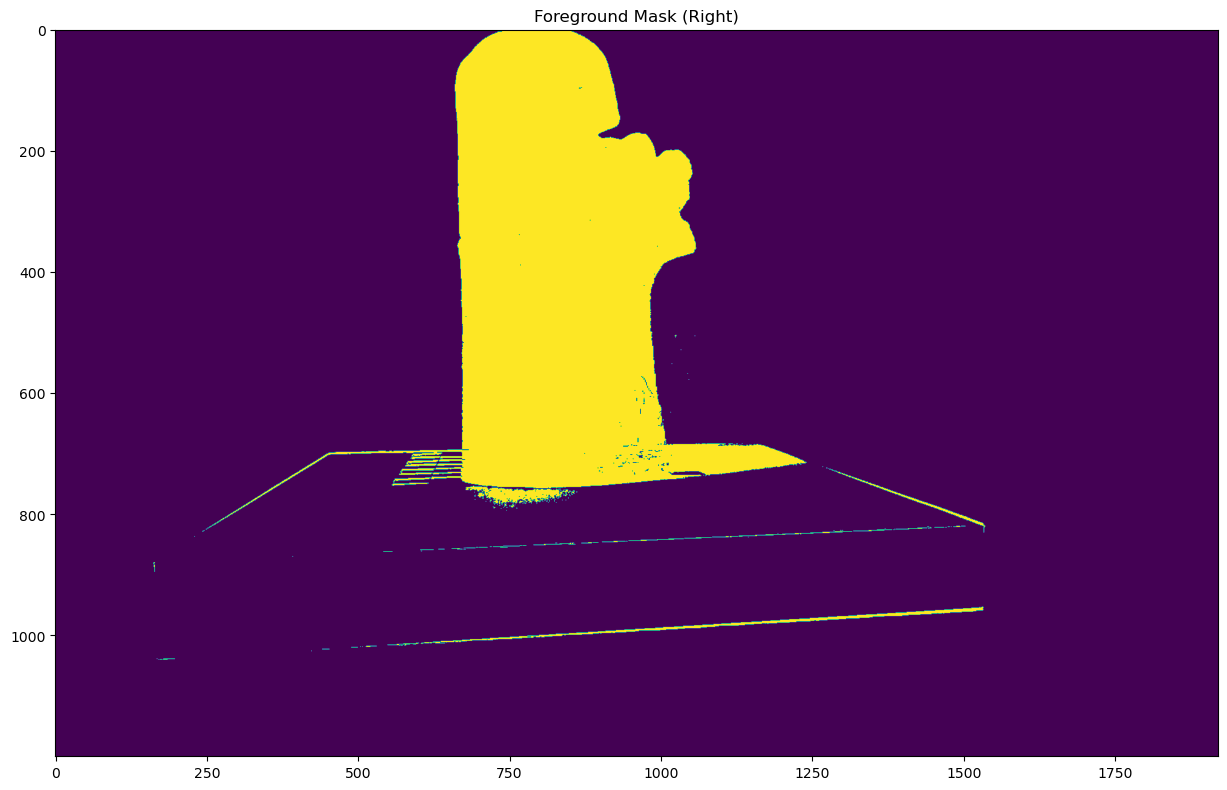

In [8]:
#generate a mask from the background image and the object, and display it for fine tuning


def gen_foreground_mask(fnameL_bg, fnameL_fg, fnameR_bg, fnameR_fg, threshold):  
    
    imL_bg = plt.imread(fnameL_bg)
    imL_fg = plt.imread(fnameL_fg)
    imR_bg = plt.imread(fnameR_bg)
    imR_fg = plt.imread(fnameR_fg)
    
    assert imL_bg.shape == imL_fg.shape and imR_bg.shape == imR_fg.shape and imR_bg.shape == imL_fg.shape
    
    (h, w, _) = imL_bg.shape
    
    foreground_mask_L = np.zeros((h,w))
    foreground_mask_R = np.zeros((h,w))
    color_difference_L = np.linalg.norm(imL_fg - imL_bg, axis=2)
    foreground_mask_L[color_difference_L > threshold] = 1
    color_difference_R = np.linalg.norm(imR_fg - imR_bg, axis=2)
    foreground_mask_R[color_difference_R > threshold] = 1
    return foreground_mask_L, foreground_mask_R


fnameL_bg = "CS117_S20_shared\\couple\\grab_0_u\\color_C0_00.png"
fnameL_fg = "CS117_S20_shared\couple\grab_0_u\color_C0_01.png"
fnameR_bg = "CS117_S20_shared\couple\grab_0_u\color_C1_00.png"
fnameR_fg = "CS117_S20_shared\couple\grab_0_u\color_C1_01.png"
foreground_mask_L, foreground_mask_R = gen_foreground_mask(fnameL_bg, fnameL_fg, fnameR_bg, fnameR_fg, 0.13)

plt.imshow(foreground_mask_L)
plt.title('Foreground Mask (Left)')
plt.show()

plt.imshow(foreground_mask_R)
plt.title('Foreground Mask (Right)')
plt.show()

mask_pickle = open("mask.pickle", "wb")
pickle.dump((foreground_mask_L, foreground_mask_R), mask_pickle)
mask_pickle.close()




Now, use the masks and generate all of pts3, pts2L, pts2R, color2L, and color2R. Test this functionality on the first image in grab_0_u.

In [9]:
#generate all points properly

def generate_pts(imprefixL, imprefixR, decode_thresh, foreground_thresh, fnameL_bg, fnameL_fg, fnameR_bg, fnameR_fg):
    #returns pts3, pts2L, pts2R, color_L, color_R synced
    foreground_mask_L, foreground_mask_R = gen_foreground_mask(fnameL_bg, fnameL_fg, fnameR_bg, fnameR_fg, foreground_thresh)
    pts2L,pts2R,pts3, color2L, color2R = color_reconstruct(imprefixL,imprefixR,decode_thresh,camL,camR, foreground_mask_L, foreground_mask_R, fnameL_fg, fnameR_fg)
    return pts2L,pts2R,pts3, color2L, color2R

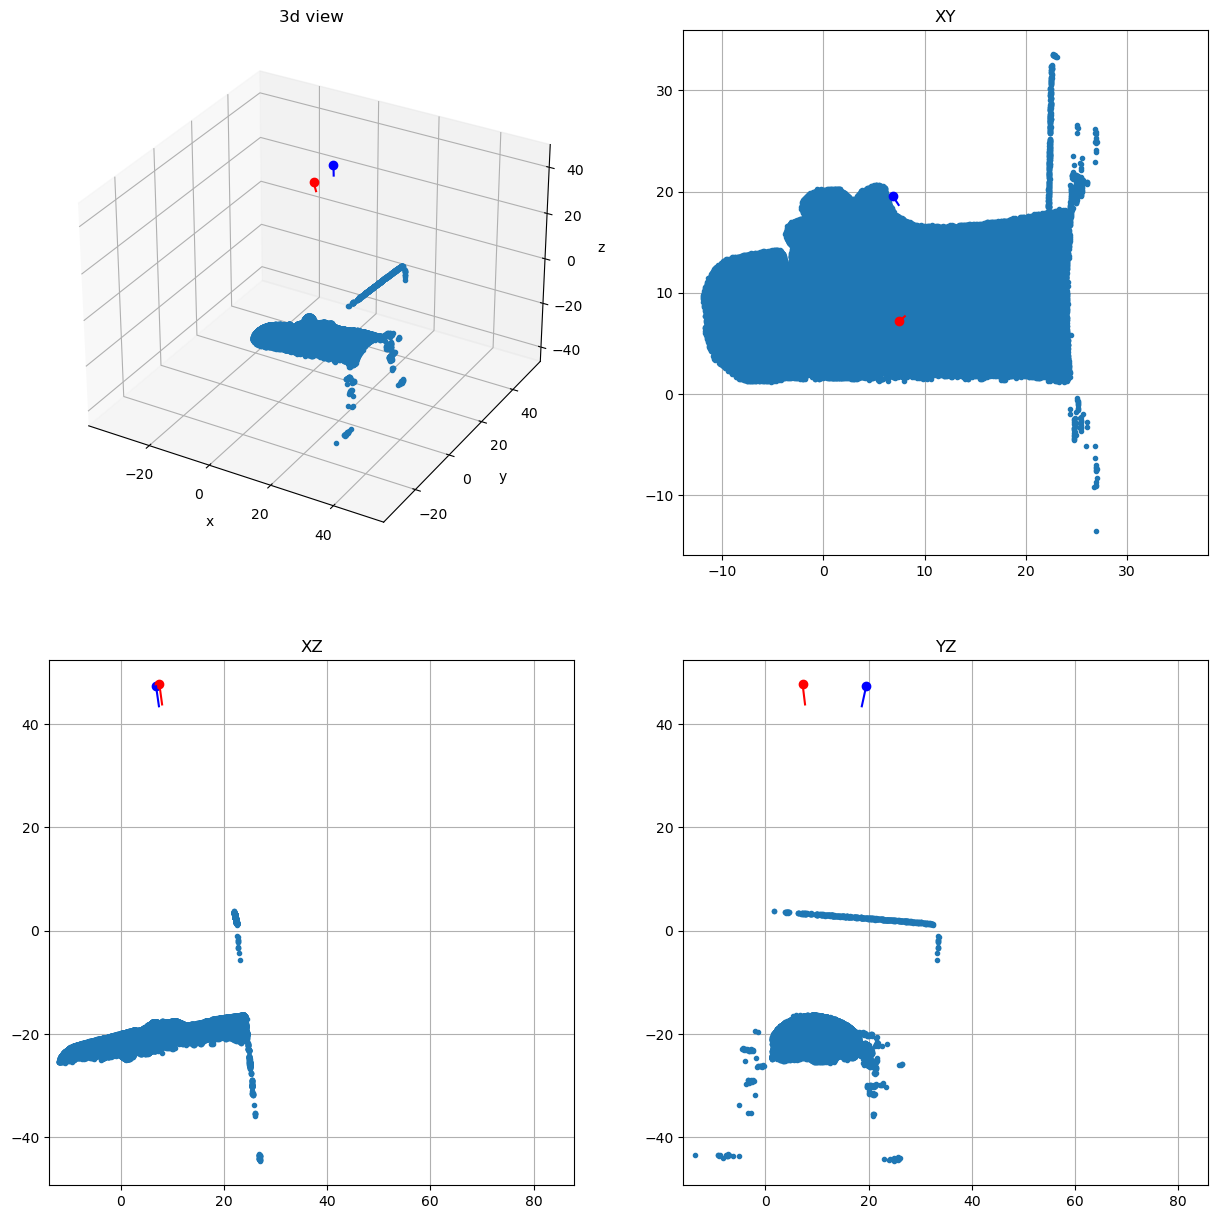

In [10]:
#test to make sure points are good
def test_plot_3d():
    imprefixL = "CS117_S20_shared\\couple\\grab_0_u\\frame_C0_"
    imprefixR = "CS117_S20_shared\\couple\\grab_0_u\\frame_C1_"
    fnameL_bg = "CS117_S20_shared\couple\grab_0_u\color_C0_00.png"
    fnameL_fg = "CS117_S20_shared\couple\grab_0_u\color_C0_01.png"
    fnameR_bg = "CS117_S20_shared\couple\grab_0_u\color_C1_00.png"
    fnameR_fg = "CS117_S20_shared\couple\grab_0_u\color_C1_01.png" 
    pts2L,pts2R,pts3, color2L, color2R = generate_pts(imprefixL, imprefixR, 0.02, 0.13, fnameL_bg, fnameL_fg, fnameR_bg, fnameR_fg)
    plot3d(pts3, camL, camR)
test_plot_3d()

# 3. Smoothing and mesh generation

Now that we have points3, we have to use Delauney to generate triangles, as well as implement smoothing. This is all done here, where boundary pruning, triangle pruning, and mesh smoothing occurs.

In [11]:
#now that we have proper point generation code, lets implement mesh smoothing
def longest_edge(indices, points):
        # Extract the three points from the indices
        p1 = points[indices[0]]
        p2 = points[indices[1]]
        p3 = points[indices[2]]

        # Calculate the squared distances between the points
        d1 = np.sum((p1 - p2) ** 2)
        d2 = np.sum((p2 - p3) ** 2)
        d3 = np.sum((p3 - p1) ** 2)

        # Determine the longest side length
        longest_edge = np.sqrt(max(d1, d2, d3))

        return longest_edge

def gen_smooth_mesh(pts3, pts2L, pts2R, colorL, colorR, num_smooth, boxRange, trithresh):
#     print("pts3 shape: ", pts3.shape)
#     print("pts2R shape: ", pts2R.shape)
#     print("pts2L shape: ", pts2L.shape)
#     print("colorL shape: ", colorL.shape)
#     print("colorR shape: ", colorR.shape)

    #boundary pruning
    nonzero_pts3_indx = np.nonzero(pts3[0, :])
    nonzero_pts3x = pts3[0, nonzero_pts3_indx]
    avgX = np.average(nonzero_pts3x)

    nonzero_pts3_indy = np.nonzero(pts3[1, :])
    nonzero_pts3y = pts3[1, nonzero_pts3_indy]
    avgY = np.average(nonzero_pts3y)

    nonzero_pts3_indz = np.nonzero(pts3[2, :])
    nonzero_pts3z = pts3[2, nonzero_pts3_indz]
    avgZ = np.average(nonzero_pts3z)

    boxlimits = np.array([avgX - boxRange, avgX + boxRange, avgY - boxRange, avgY + boxRange, avgZ - boxRange, avgZ + boxRange])

    mask = np.ones(pts3.shape[1], dtype=bool)
    for i in range(pts3.shape[1]):
        if pts3[0, i] < boxlimits[0] or pts3[0, i] > boxlimits[1] or pts3[1, i] < boxlimits[2] or pts3[1, i] > boxlimits[3] or pts3[2, i] < boxlimits[4] or pts3[2, i] > boxlimits[5]:
            mask[i] = False
    pts3 = pts3[:, mask]
    pts2L = pts2L[:, mask]
    pts2R = pts2R[:, mask]
    colorL = colorL[:, mask]
    colorR = colorR[:, mask]
    #triangle pruning

    tri = scipy.spatial.Delaunay(pts2L.T).simplices
    tri_mask = np.ones(tri.shape[0], dtype=bool)
    
    mapFromPointToNeighbors = {}
    
    for i in range(tri.shape[0]):
        if longest_edge((tri[i, 0], tri[i, 1], tri[i, 2]), pts2L.T) > trithresh:
            tri_mask[i] = False
        else:
            if tri[i, 0] not in mapFromPointToNeighbors:
                mapFromPointToNeighbors[tri[i, 0]] = set()
            if tri[i, 1] not in mapFromPointToNeighbors:
                mapFromPointToNeighbors[tri[i, 1]] = set()
            if tri[i, 2] not in mapFromPointToNeighbors:
                mapFromPointToNeighbors[tri[i, 2]] = set() 
            
            mapFromPointToNeighbors[tri[i, 0]].add(tri[i, 1])
            mapFromPointToNeighbors[tri[i, 0]].add(tri[i, 2])
            mapFromPointToNeighbors[tri[i, 1]].add(tri[i, 0])
            mapFromPointToNeighbors[tri[i, 1]].add(tri[i, 2])
            mapFromPointToNeighbors[tri[i, 2]].add(tri[i, 0])
            mapFromPointToNeighbors[tri[i, 2]].add(tri[i, 1])
    tri = tri[tri_mask, :]

    for _ in range(num_smooth):
        npts3 = np.ones(pts3.shape)
        for k, v in mapFromPointToNeighbors.items():
            npts3[0][k] = np.average([pts3[0][x] for x in v])
            npts3[1][k] = np.average([pts3[1][x] for x in v])
            npts3[2][k] = np.average([pts3[2][x] for x in v])
        pts3 = npts3
    
    return pts3, pts2L, pts2R, colorL, colorR, tri

To see the effect of the smoothing, visualize each mesh with 0, 1, 3, and 5 smooth iterations

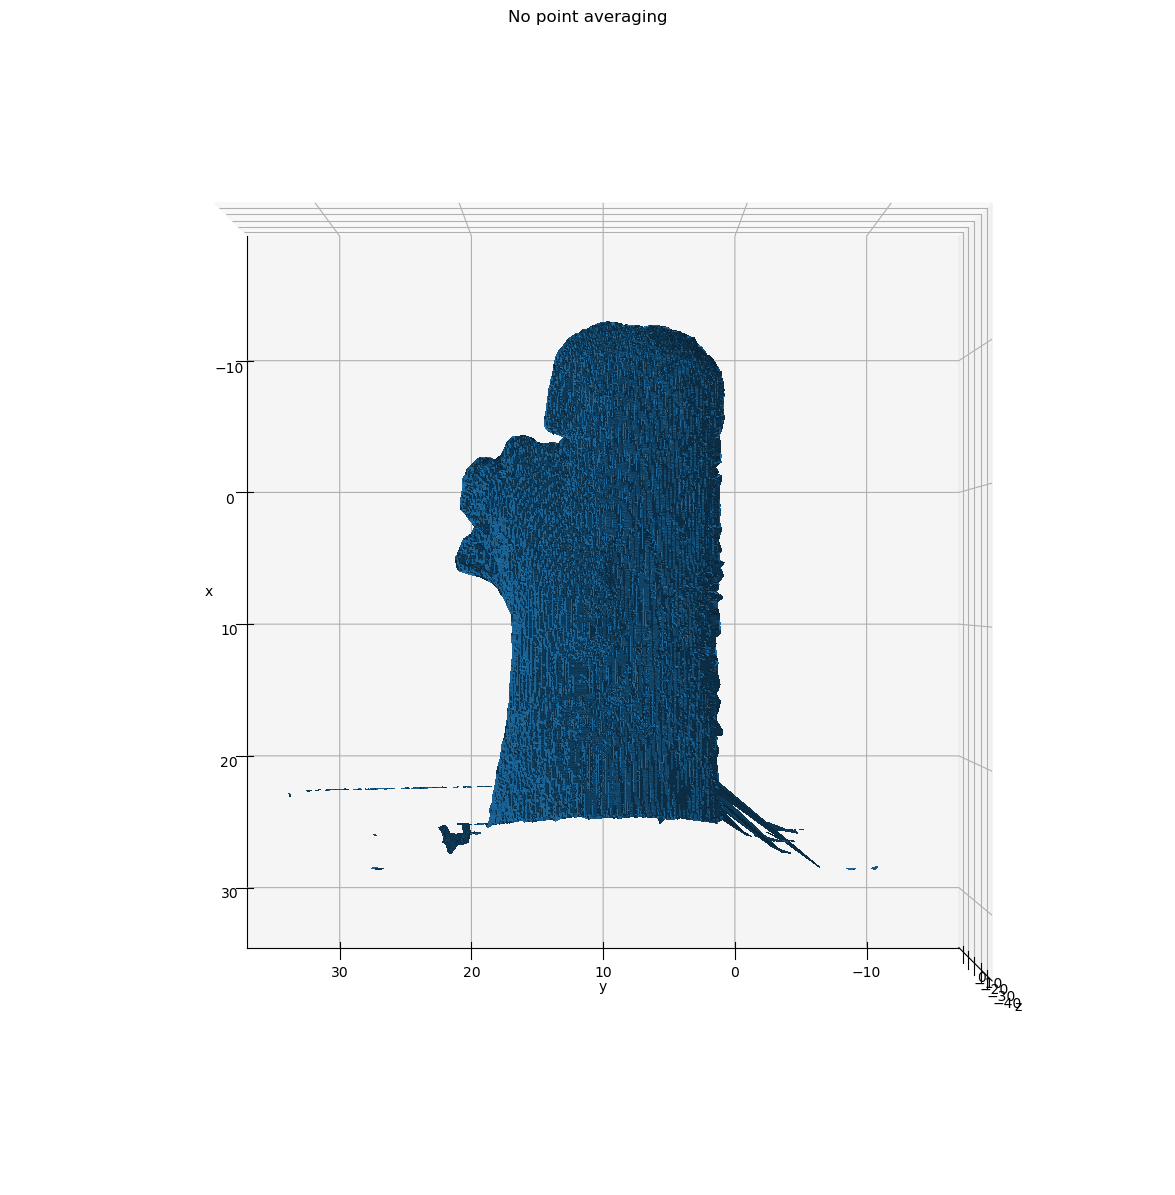

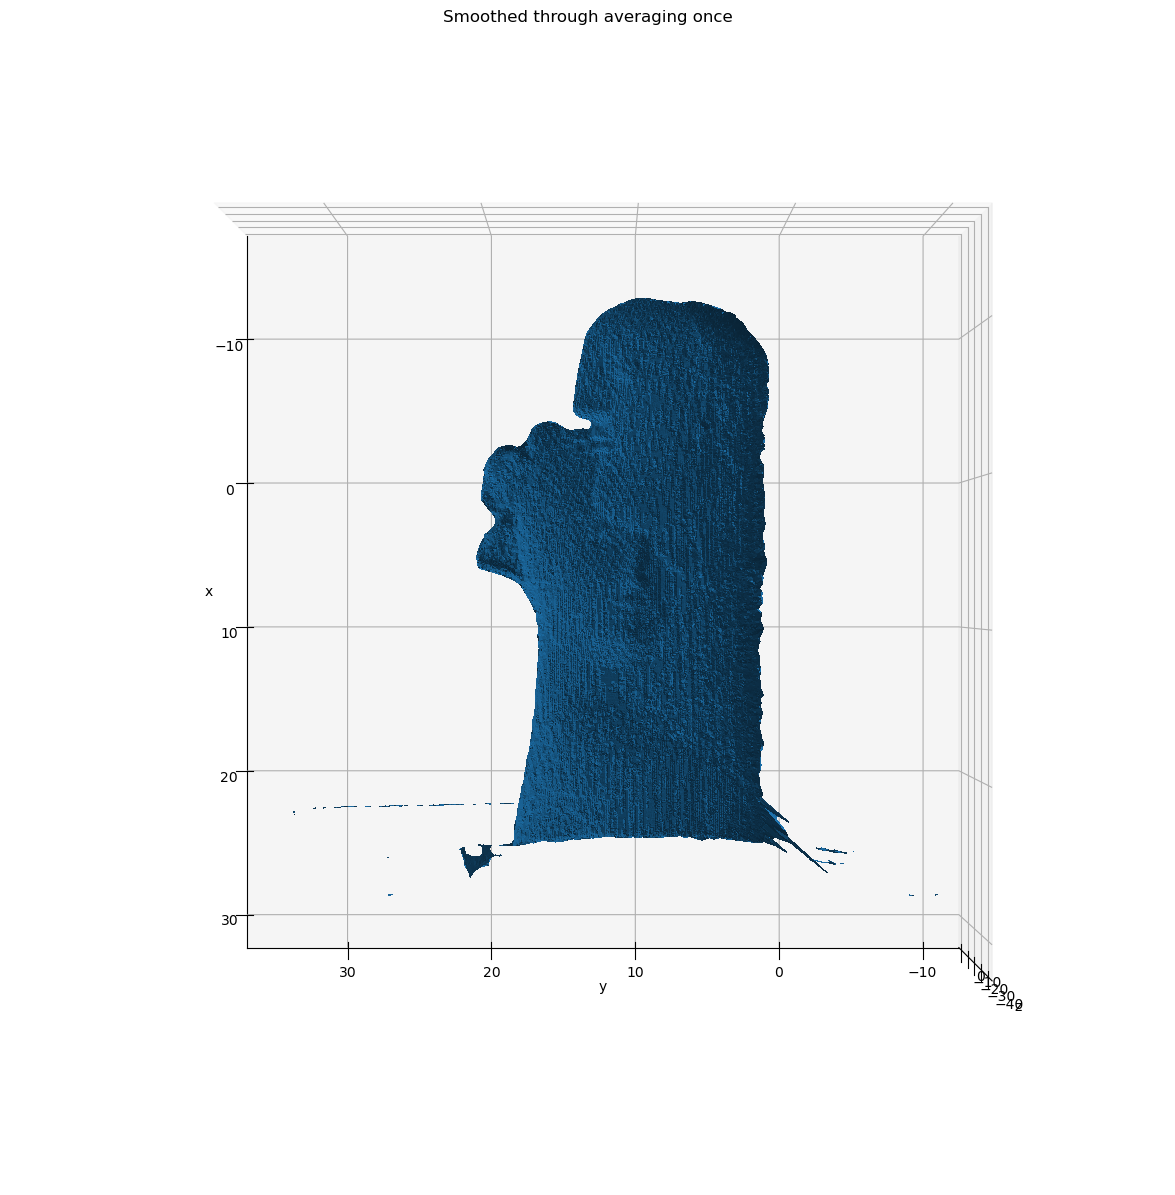

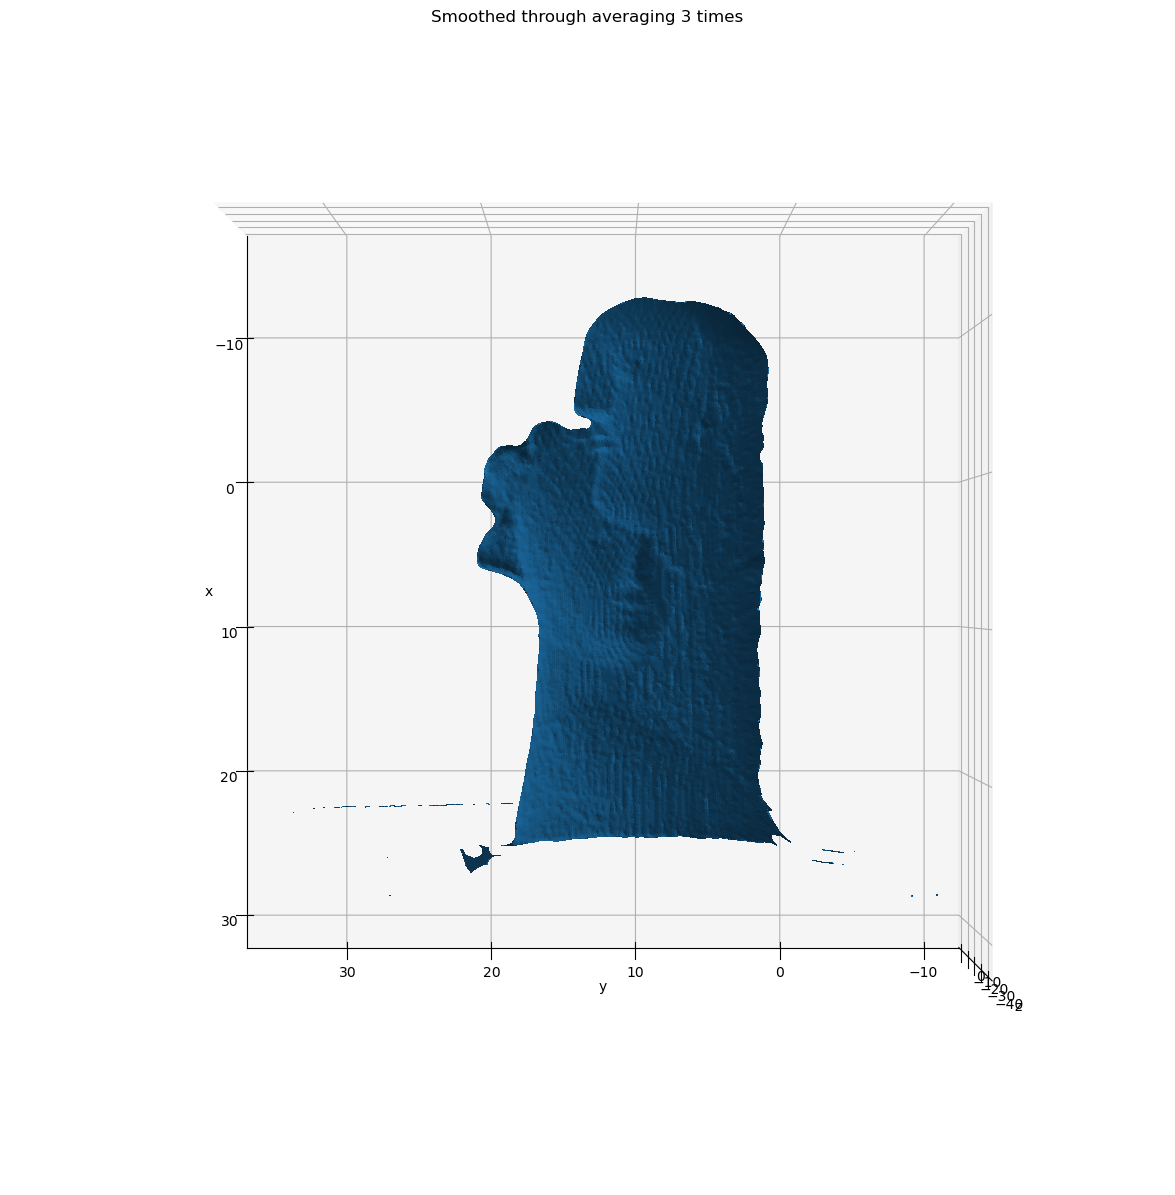

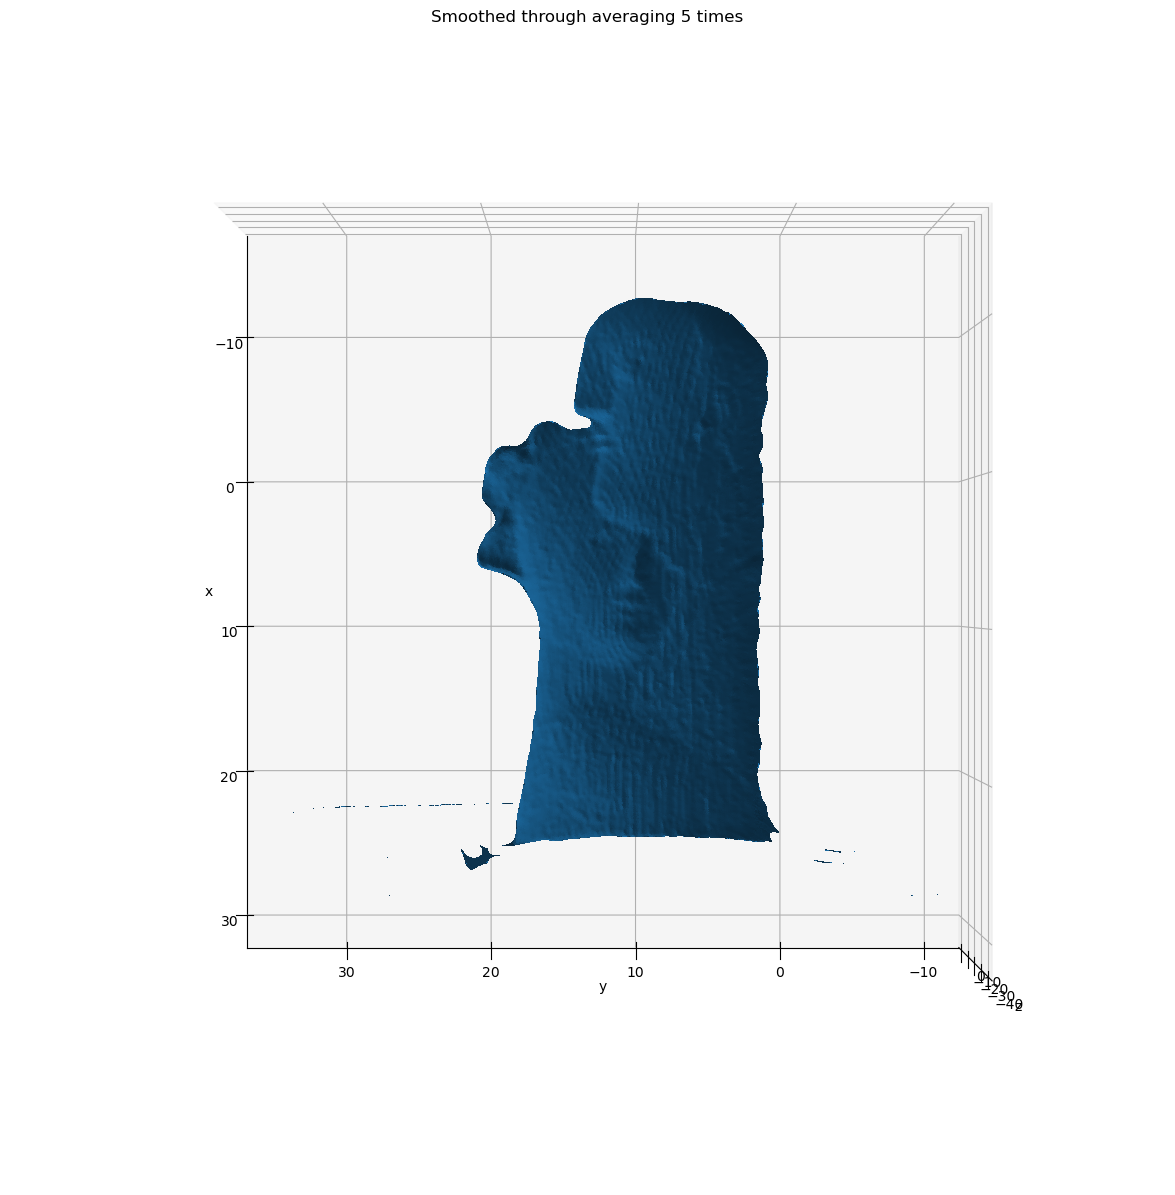

In [13]:

imprefixL = "CS117_S20_shared\\couple\\grab_0_u\\frame_C0_"
imprefixR = "CS117_S20_shared\\couple\\grab_0_u\\frame_C1_"
fnameL_bg = "CS117_S20_shared\couple\grab_0_u\color_C0_00.png"
fnameL_fg = "CS117_S20_shared\couple\grab_0_u\color_C0_01.png"
fnameR_bg = "CS117_S20_shared\couple\grab_0_u\color_C1_00.png"
fnameR_fg = "CS117_S20_shared\couple\grab_0_u\color_C1_01.png" 
pts2L,pts2R,pts3, color2L, color2R = generate_pts(imprefixL, imprefixR, 0.02, 0.13, fnameL_bg, fnameL_fg, fnameR_bg, fnameR_fg)
    
pts3_0, pts2L_0, pts2R_0, colorL_0, colorR_0, tri_0 = gen_smooth_mesh(pts3, pts2L, pts2R, color2L, color2R, 0, 200, 12)
visualize_basic_mesh(pts3_0, tri_0, "No point averaging")

pts3_1, pts2L_1, pts2R_1, colorL_1, colorR_1, tri_1 = gen_smooth_mesh(pts3, pts2L, pts2R, color2L, color2R, 1, 200, 12)
visualize_basic_mesh(pts3_1, tri_1, "Smoothed through averaging once")

pts3_3, pts2L_3, pts2R_3, colorL_3, colorR_3, tri_3 = gen_smooth_mesh(pts3, pts2L, pts2R, color2L, color2R, 3, 200, 12)
visualize_basic_mesh(pts3_3, tri_3, "Smoothed through averaging 3 times")

pts3_5, pts2L_5, pts2R_5, colorL_5, colorR_5, tri_5 = gen_smooth_mesh(pts3, pts2L, pts2R, color2L, color2R, 5, 200, 12)
visualize_basic_mesh(pts3_5, tri_5, "Smoothed through averaging 5 times")

To me, I liked the smoothing with 3 the most since I didn't lose too much detail but also got rid of the graininess. Now, simply generate every smooth mesh with every rotation angle of the couple object. Then, save each mesh in a ply file to be used in Meshlab.

In [14]:
num_smooths = 3

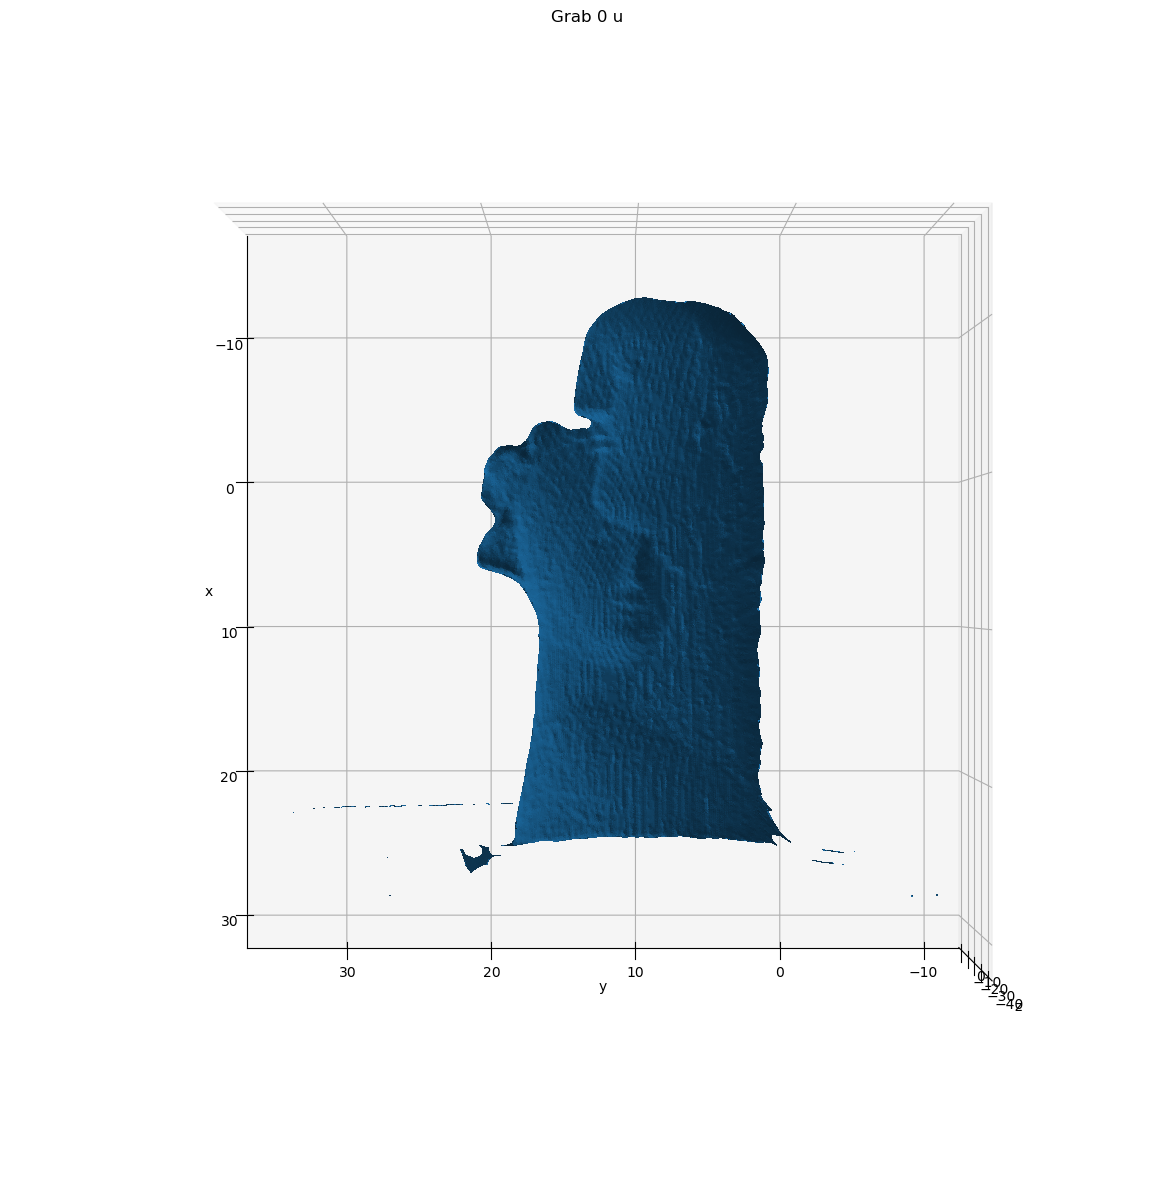

In [15]:
imprefixL_0 = "CS117_S20_shared\\couple\\grab_0_u\\frame_C0_"
imprefixR_0 = "CS117_S20_shared\\couple\\grab_0_u\\frame_C1_"
fnameL_bg_0 = "CS117_S20_shared\couple\grab_0_u\color_C0_00.png"
fnameL_fg_0 = "CS117_S20_shared\couple\grab_0_u\color_C0_01.png"
fnameR_bg_0 = "CS117_S20_shared\couple\grab_0_u\color_C1_00.png"
fnameR_fg_0 = "CS117_S20_shared\couple\grab_0_u\color_C1_01.png" 
pts2L_0,pts2R_0,pts3_0, color2L_0, color2R_0 = generate_pts(imprefixL_0, imprefixR_0, 0.02, 0.13, fnameL_bg_0, fnameL_fg_0, fnameR_bg_0, fnameR_fg_0)
pts3_0, pts2L_0, pts2R_0, colorL_0, colorR_0, tri_0 = gen_smooth_mesh(pts3_0, pts2L_0, pts2R_0, color2L_0, color2R_0, num_smooths, 200, 12)
visualize_basic_mesh(pts3_0, tri_0, "Grab 0 u")
color_0 = (colorL_0 + colorR_0)/2
writeply(pts3_0, color_0, tri_0, "mesh_grab_0.ply")


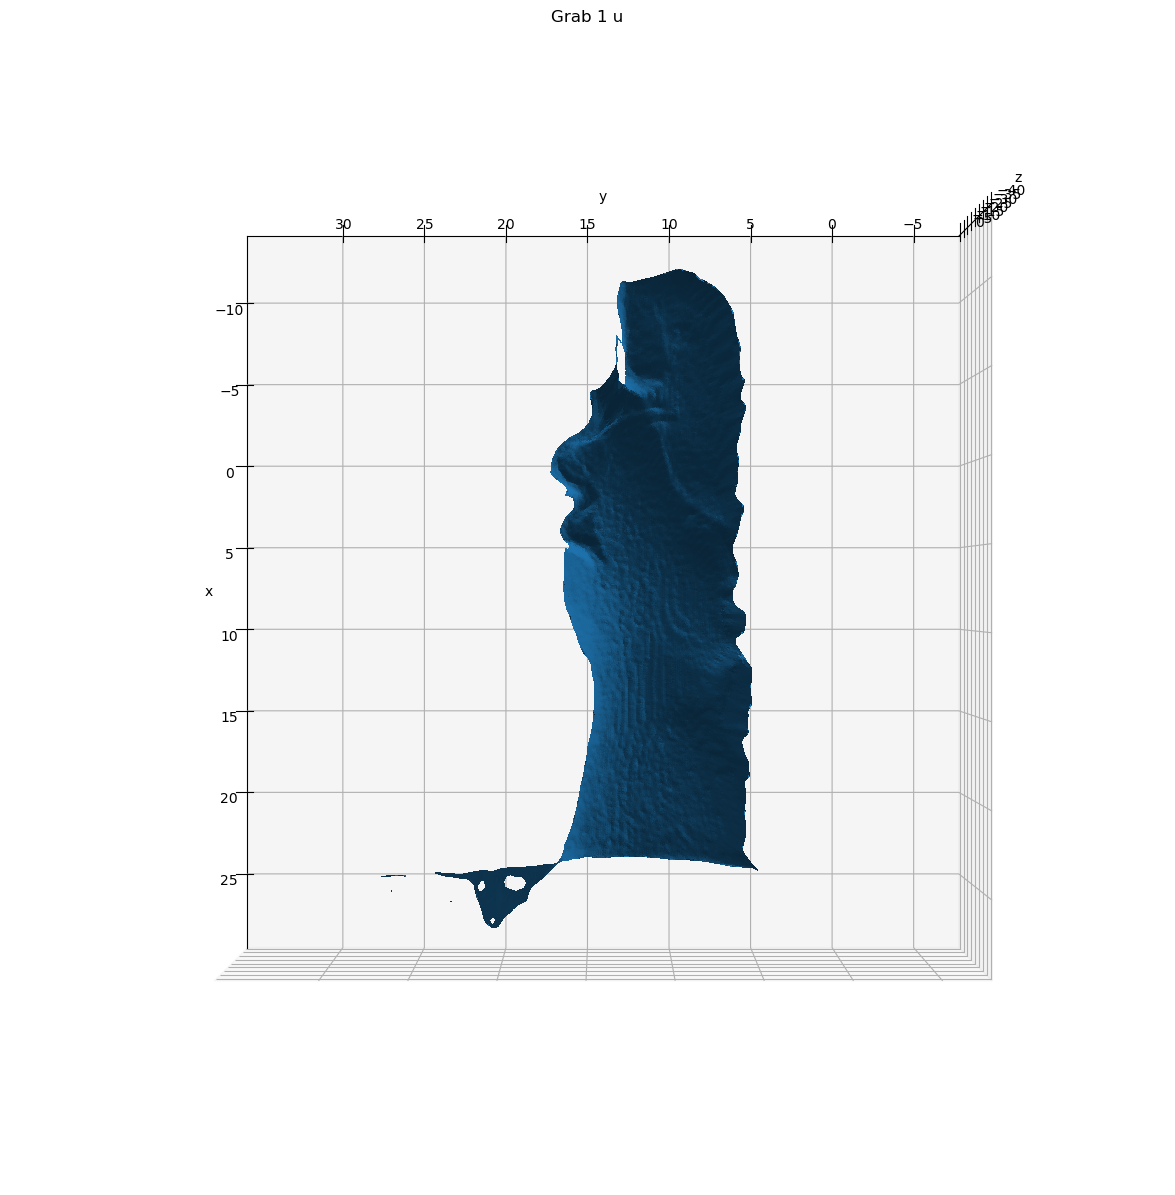

In [16]:
imprefixL_1 = "CS117_S20_shared\\couple\\grab_1_u\\frame_C0_"
imprefixR_1 = "CS117_S20_shared\\couple\\grab_1_u\\frame_C1_"
fnameL_bg_1 = "CS117_S20_shared\couple\grab_1_u\color_C0_00.png"
fnameL_fg_1 = "CS117_S20_shared\couple\grab_1_u\color_C0_01.png"
fnameR_bg_1 = "CS117_S20_shared\couple\grab_1_u\color_C1_00.png"
fnameR_fg_1 = "CS117_S20_shared\couple\grab_1_u\color_C1_01.png" 
pts2L_1,pts2R_1,pts3_1, color2L_1, color2R_1 = generate_pts(imprefixL_1, imprefixR_1, 0.02, 0.13, fnameL_bg_1, fnameL_fg_1, fnameR_bg_1, fnameR_fg_1)
pts3_1, pts2L_1, pts2R_1, colorL_1, colorR_1, tri_1 = gen_smooth_mesh(pts3_1, pts2L_1, pts2R_1, color2L_1, color2R_1, num_smooths, 200, 12)
visualize_basic_mesh(pts3_1, tri_1, "Grab 1 u")
color_1 = (colorL_1 + colorR_1)/2
writeply(pts3_1, color_1, tri_1, "mesh_grab_1.ply")

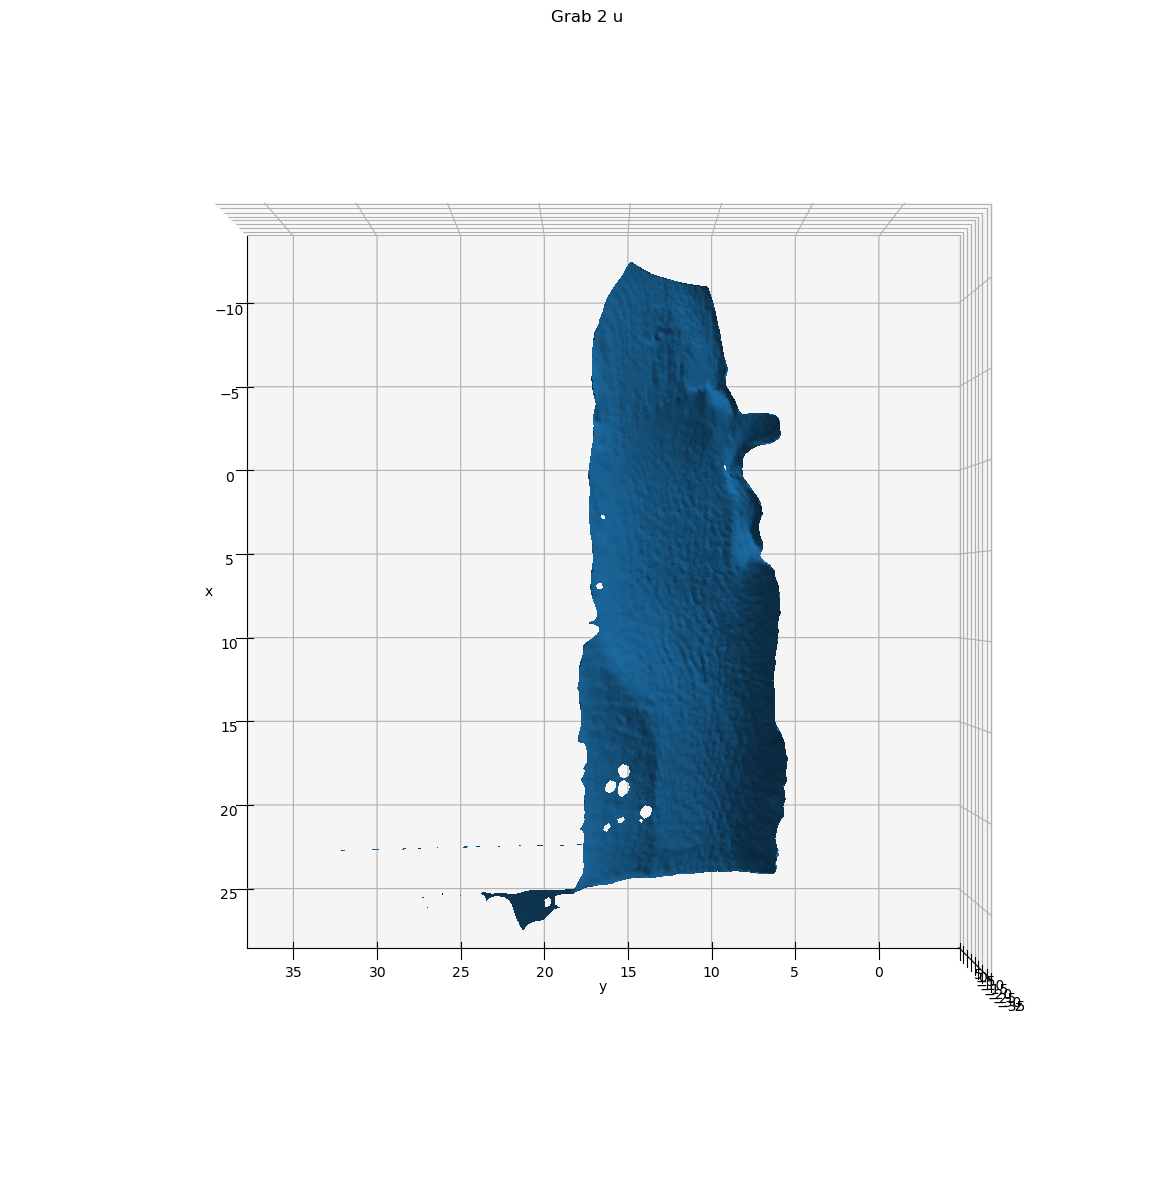

In [17]:
imprefixL_2 = "CS117_S20_shared\\couple\\grab_2_u\\frame_C0_"
imprefixR_2 = "CS117_S20_shared\\couple\\grab_2_u\\frame_C1_"
fnameL_bg_2 = "CS117_S20_shared\couple\grab_2_u\color_C0_00.png"
fnameL_fg_2 = "CS117_S20_shared\couple\grab_2_u\color_C0_01.png"
fnameR_bg_2 = "CS117_S20_shared\couple\grab_2_u\color_C1_00.png"
fnameR_fg_2 = "CS117_S20_shared\couple\grab_2_u\color_C1_01.png" 
pts2L_2,pts2R_2,pts3_2, color2L_2, color2R_2 = generate_pts(imprefixL_2, imprefixR_2, 0.02, 0.13, fnameL_bg_2, fnameL_fg_2, fnameR_bg_2, fnameR_fg_2)
pts3_2, pts2L_2, pts2R_2, colorL_2, colorR_2, tri_2 = gen_smooth_mesh(pts3_2, pts2L_2, pts2R_2, color2L_2, color2R_2, num_smooths, 200, 12)
visualize_basic_mesh(pts3_2, tri_2, "Grab 2 u")
color_2 = (colorL_2 + colorR_2)/2
writeply(pts3_2, color_2, tri_2, "mesh_grab_2.ply")

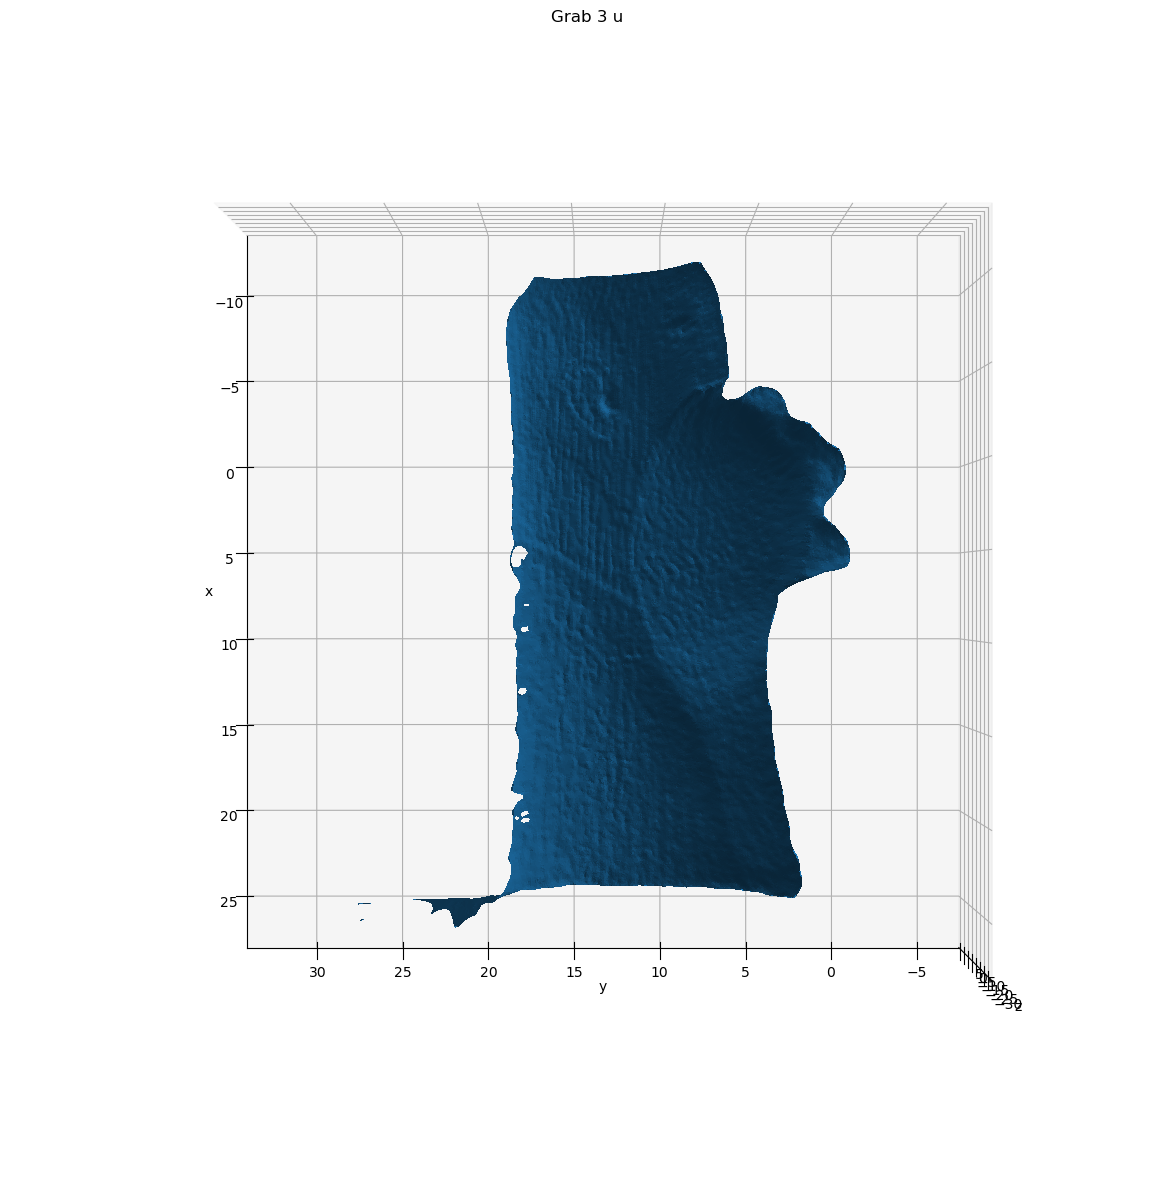

In [18]:
imprefixL_3 = "CS117_S20_shared\\couple\\grab_3_u\\frame_C0_"
imprefixR_3 = "CS117_S20_shared\\couple\\grab_3_u\\frame_C1_"
fnameL_bg_3 = "CS117_S20_shared\couple\grab_3_u\color_C0_00.png"
fnameL_fg_3 = "CS117_S20_shared\couple\grab_3_u\color_C0_01.png"
fnameR_bg_3 = "CS117_S20_shared\couple\grab_3_u\color_C1_00.png"
fnameR_fg_3 = "CS117_S20_shared\couple\grab_3_u\color_C1_01.png" 
pts2L_3,pts2R_3,pts3_3, color2L_3, color2R_3 = generate_pts(imprefixL_3, imprefixR_3, 0.02, 0.13, fnameL_bg_3, fnameL_fg_3, fnameR_bg_3, fnameR_fg_3)
pts3_3, pts2L_3, pts2R_3, colorL_3, colorR_3, tri_3 = gen_smooth_mesh(pts3_3, pts2L_3, pts2R_3, color2L_3, color2R_3, num_smooths, 200, 12)
visualize_basic_mesh(pts3_3, tri_3, "Grab 3 u")
color_3 = (colorL_3 + colorR_3)/2
writeply(pts3_3, color_3, tri_3, "mesh_grab_3.ply")

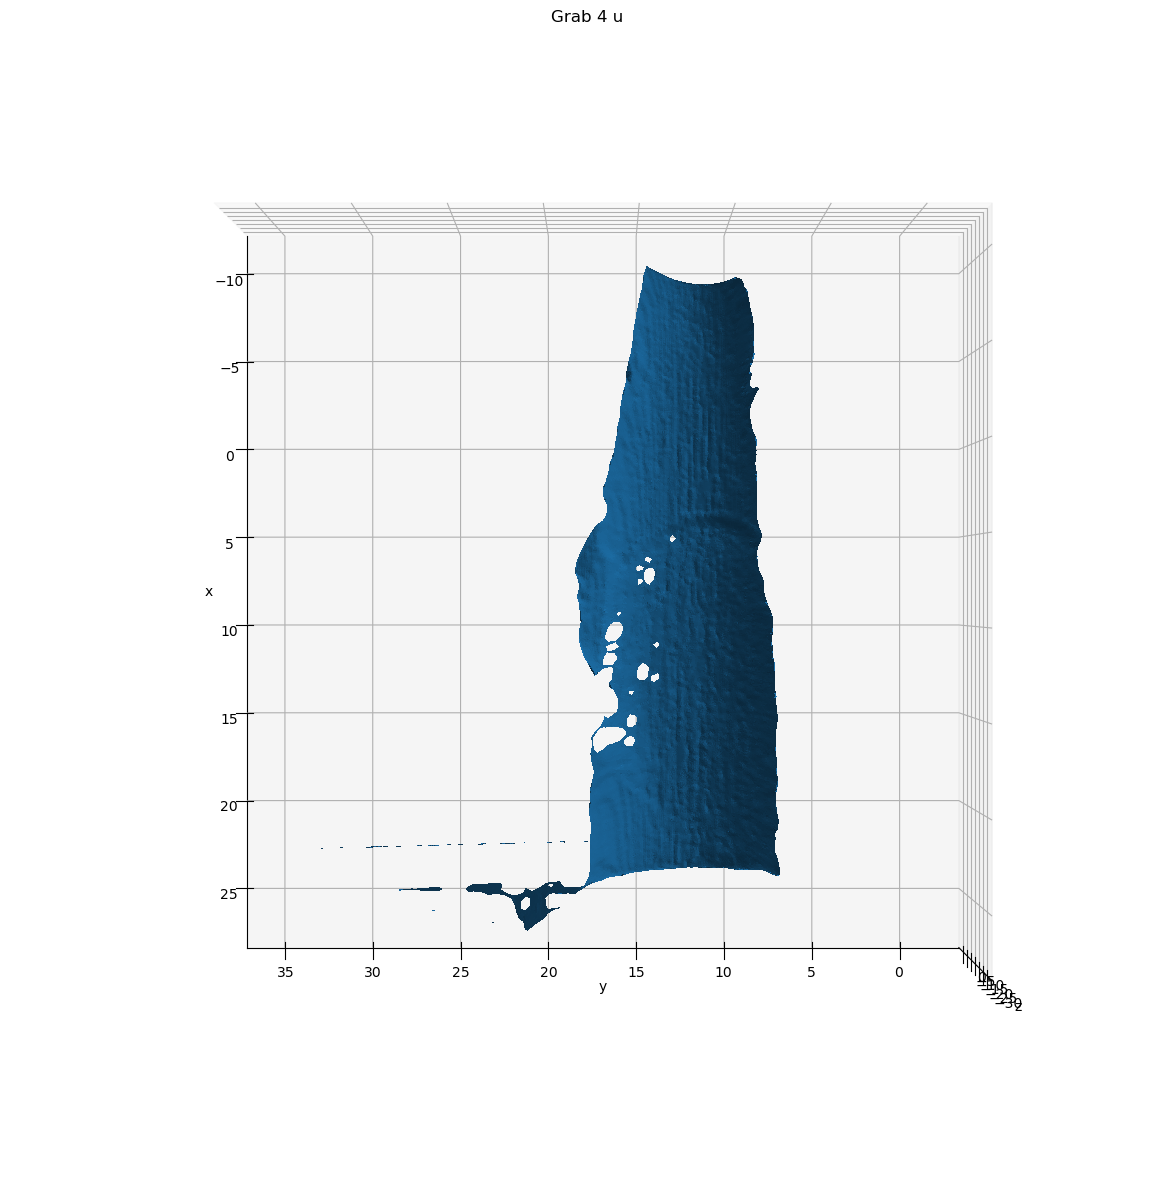

In [19]:
imprefixL_4 = "CS117_S20_shared\\couple\\grab_4_u\\frame_C0_"
imprefixR_4 = "CS117_S20_shared\\couple\\grab_4_u\\frame_C1_"
fnameL_bg_4 = "CS117_S20_shared\couple\grab_4_u\color_C0_00.png"
fnameL_fg_4 = "CS117_S20_shared\couple\grab_4_u\color_C0_01.png"
fnameR_bg_4 = "CS117_S20_shared\couple\grab_4_u\color_C1_00.png"
fnameR_fg_4 = "CS117_S20_shared\couple\grab_4_u\color_C1_01.png" 
pts2L_4,pts2R_4,pts3_4, color2L_4, color2R_4 = generate_pts(imprefixL_4, imprefixR_4, 0.02, 0.13, fnameL_bg_4, fnameL_fg_4, fnameR_bg_4, fnameR_fg_4)
pts3_4, pts2L_4, pts2R_4, colorL_4, colorR_4, tri_4 = gen_smooth_mesh(pts3_4, pts2L_4, pts2R_4, color2L_4, color2R_4, num_smooths, 200, 12)
visualize_basic_mesh(pts3_4, tri_4, "Grab 4 u")
color_4 = (colorL_4 + colorR_4)/2
writeply(pts3_4, color_4, tri_4, "mesh_grab_4.ply")


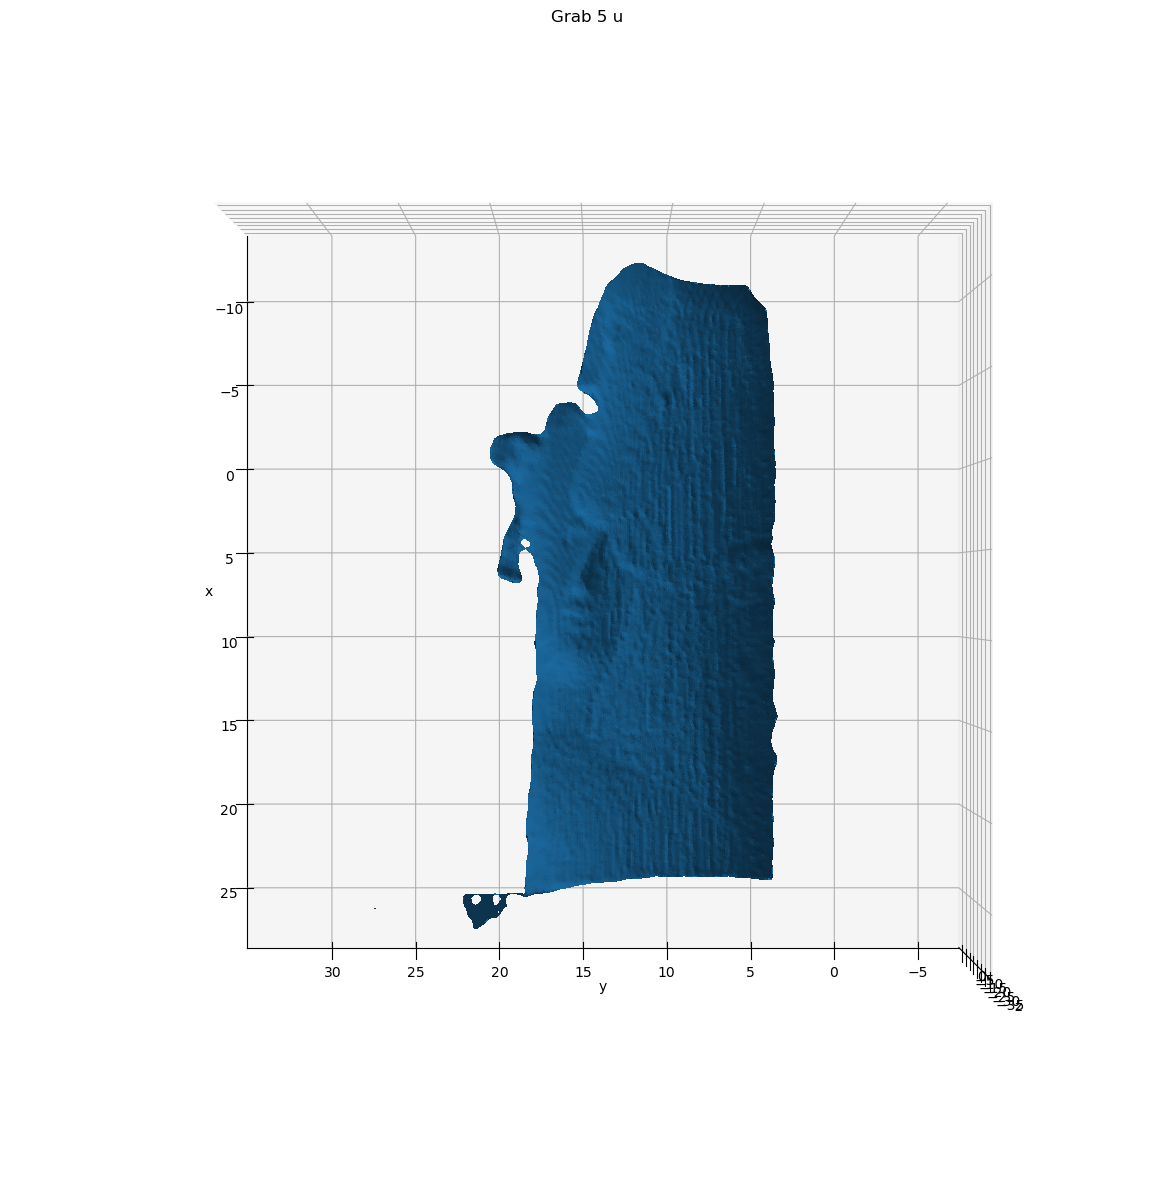

In [20]:
imprefixL_5 = "CS117_S20_shared\\couple\\grab_5_u\\frame_C0_"
imprefixR_5 = "CS117_S20_shared\\couple\\grab_5_u\\frame_C1_"
#empty background not found, use grab4
fnameL_bg_5 = "CS117_S20_shared\couple\grab_4_u\color_C0_00.png"
fnameL_fg_5 = "CS117_S20_shared\couple\grab_5_u\color_C0_00.png"
fnameR_bg_5 = "CS117_S20_shared\couple\grab_4_u\color_C1_00.png"
fnameR_fg_5 = "CS117_S20_shared\couple\grab_5_u\color_C1_00.png" 
pts2L_5,pts2R_5,pts3_5, color2L_5, color2R_5 = generate_pts(imprefixL_5, imprefixR_5, 0.02, 0.13, fnameL_bg_5, fnameL_fg_5, fnameR_bg_5, fnameR_fg_5)
pts3_5, pts2L_5, pts2R_5, colorL_5, colorR_5, tri_5 = gen_smooth_mesh(pts3_5, pts2L_5, pts2R_5, color2L_5, color2R_5, num_smooths, 200, 12)
visualize_basic_mesh(pts3_5, tri_5, "Grab 5 u")
color_5 = (colorL_5 + colorR_5)/2
writeply(pts3_5, color_5, tri_5, "mesh_grab_5.ply")


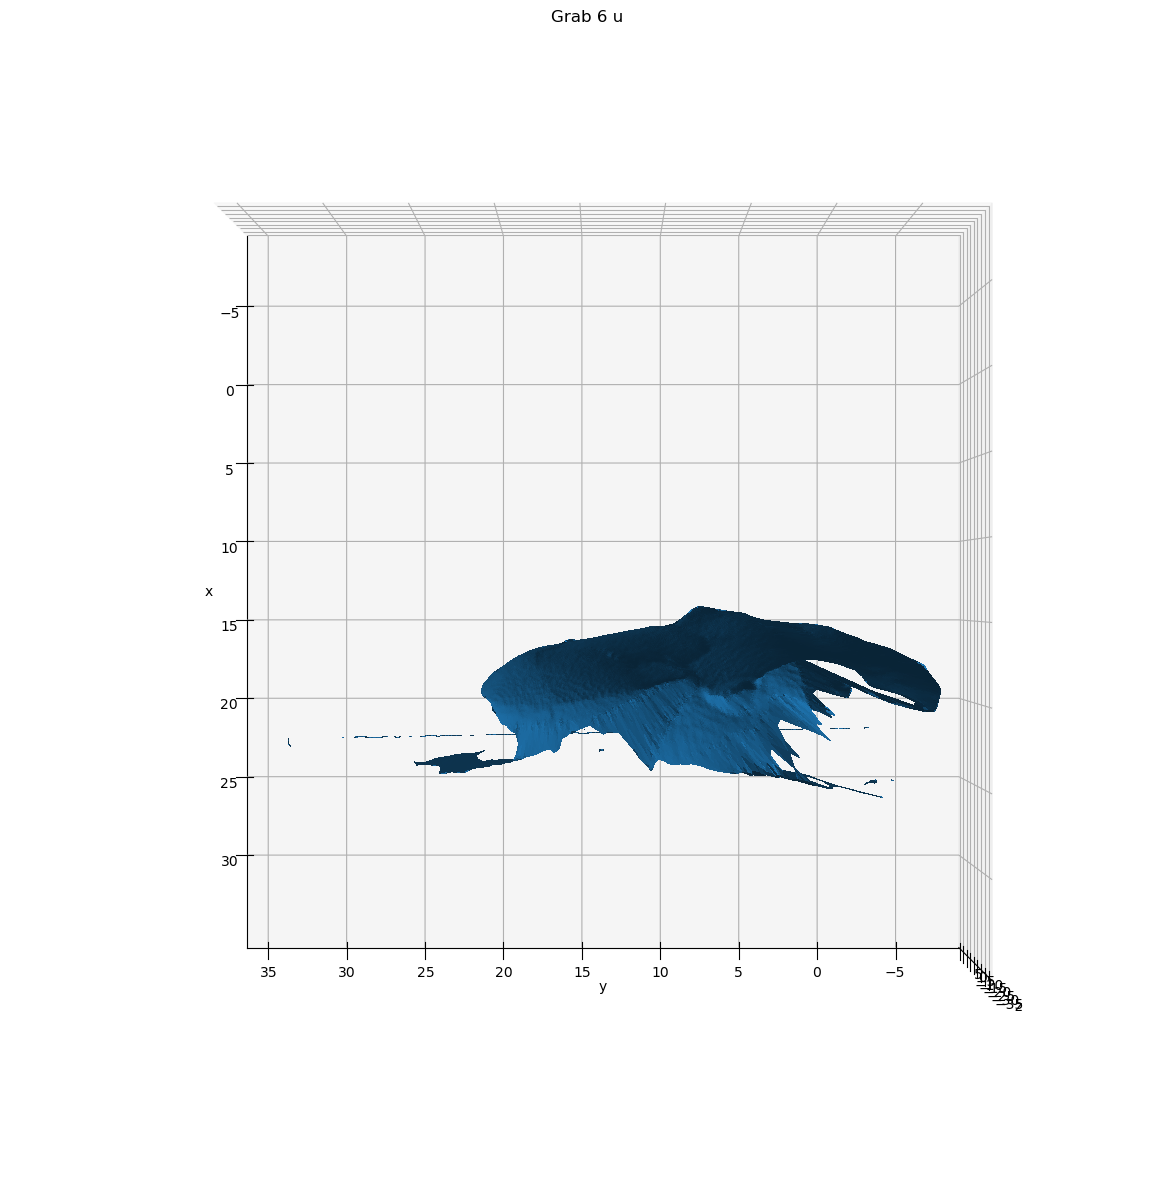

In [21]:
imprefixL_6 = "CS117_S20_shared\\couple\\grab_6_u\\frame_C0_"
imprefixR_6 = "CS117_S20_shared\\couple\\grab_6_u\\frame_C1_"
fnameL_bg_6 = "CS117_S20_shared\couple\grab_6_u\color_C0_00.png"
fnameL_fg_6 = "CS117_S20_shared\couple\grab_6_u\color_C0_01.png"
fnameR_bg_6 = "CS117_S20_shared\couple\grab_6_u\color_C1_00.png"
fnameR_fg_6 = "CS117_S20_shared\couple\grab_6_u\color_C1_01.png" 
pts2L_6,pts2R_6,pts3_6, color2L_6, color2R_6 = generate_pts(imprefixL_6, imprefixR_6, 0.02, 0.13, fnameL_bg_6, fnameL_fg_6, fnameR_bg_6, fnameR_fg_6)
pts3_6, pts2L_6, pts2R_6, colorL_6, colorR_6, tri_6 = gen_smooth_mesh(pts3_6, pts2L_6, pts2R_6, color2L_6, color2R_6, num_smooths, 200, 12)
visualize_basic_mesh(pts3_6, tri_6, "Grab 6 u")
color_6 = (colorL_6 + colorR_6)/2
writeply(pts3_6, color_6, tri_6, "mesh_grab_6.ply")


All code writing is done - each mesh has been generated and stored in a ply file, and the ply files are used in Meshlab.